<a href="https://colab.research.google.com/github/byunsy/face-recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Training

---



## 01. Import Packages

In [ ]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## 02. Upload Dataset from Local Disk

- upload a zipped folder of face dataset from local directory
- unzip the directory

In [ ]:
!unzip /content/face_dataset.zip

## 03. Understand the Dataset

Firstly, create directory paths for the base directory and its main subdirectories.

In [ ]:
# Create directory paths
base_dir = os.path.join(os.path.dirname('/content/face_dataset.zip'), 'face_dataset')

test_dir  = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')

In [ ]:
# Number of images
num_ts_unid = len(os.listdir(os.path.join(test_dir, 'UNIDENTIFIED')))
num_ts_byun = len(os.listdir(os.path.join(test_dir, 'SANGYOON')))
num_ts = num_ts_unid + num_ts_byun

num_tr_unid = len(os.listdir(os.path.join(train_dir, 'UNIDENTIFIED')))
num_tr_byun = len(os.listdir(os.path.join(train_dir, 'SANGYOON')))
num_tr = num_tr_unid + num_tr_byun

num_vl_unid = len(os.listdir(os.path.join(val_dir, 'UNIDENTIFIED')))
num_vl_byun = len(os.listdir(os.path.join(val_dir, 'SANGYOON')))
num_vl = num_vl_unid + num_vl_byun

# Display number of images in each directory
print("TOTAL NUMBER OF TEST IMAGES:", num_ts)
print("Number of UNIDENTIFIED  - TEST :", num_ts_unid)
print("Number of SANGYOON      - TEST :", num_ts_byun, "\n")

print("TOTAL NUMBER OF TRAIN IMAGES:", num_tr)
print("Number of UNIDENTIFIED  - TRAIN :", num_tr_unid)
print("Number of SANGYOON      - TRAIN :", num_tr_byun, "\n")

print("TOTAL NUMBER OF VALIDATION IMAGES:", num_vl)
print("Number of UNIDENTIFIED  - VALIDATION :", num_vl_unid)
print("Number of SANGYOON      - VALIDATION :", num_vl_byun, "\n")

print("-"*30)
print("UNIDENTIFIED IMAGES :", num_ts_unid + num_tr_unid + num_vl_unid)
print("SANGYOON IMAGES     :", num_ts_byun + num_tr_byun + num_vl_byun)

TOTAL NUMBER OF TEST IMAGES: 400
Number of UNIDENTIFIED  - TEST : 200
Number of SANGYOON      - TEST : 200 

TOTAL NUMBER OF TRAIN IMAGES: 3200
Number of UNIDENTIFIED  - TRAIN : 1600
Number of SANGYOON      - TRAIN : 1600 

TOTAL NUMBER OF VALIDATION IMAGES: 400
Number of UNIDENTIFIED  - VALIDATION : 200
Number of SANGYOON      - VALIDATION : 200 

------------------------------
UNIDENTIFIED IMAGES : 2000
SANGYOON IMAGES     : 2000


Notice that we have a perfectly even split between number of UNIDENTIFIED images and SANGYOON images. The dataset is also appropriately split into testing, validation, and training sets using a 10:10:80 ratio. 

## 04. Visualize Data

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

We set the batch size to be 100 and image shape to 128x128 pixels.

In [ ]:
BATCH_SIZE = 100
IMG_SHAPE = 128

Apply geometric transformation  like rotation, zoom, and horizontal flip to the training image datasets. 

Found 3200 images belonging to 2 classes.


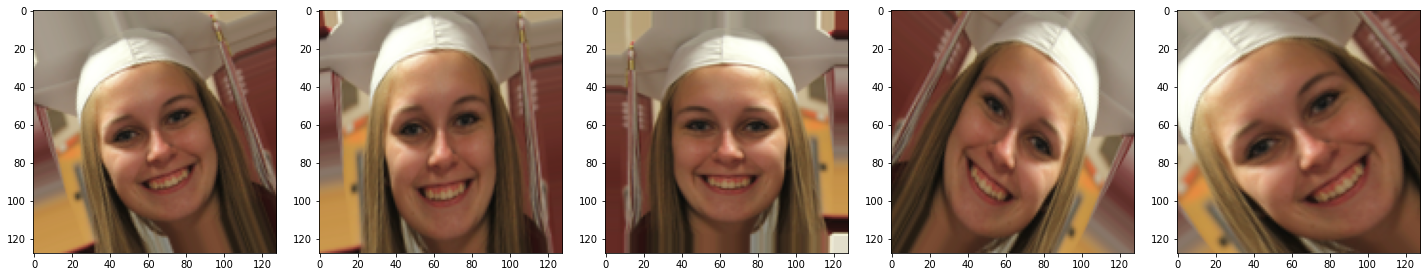

In [ ]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45, 
    zoom_range=0.25,
    horizontal_flip=True, 
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=train_dir,
                                                    shuffle=True, 
                                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                                    class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE,IMG_SHAPE),
                                                 class_mode='binary')

Found 400 images belonging to 2 classes.


In [ ]:
image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=test_dir,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='binary')

Found 400 images belonging to 2 classes.


## 05. Create CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

## 06. Compile the Model


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 07. Train the Model

In [ ]:
epochs = 10

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/10
32/32 [==============================] - 62s 2s/step - loss: 0.3810 - accuracy: 0.8338 - val_loss: 0.0367 - val_accuracy: 0.9925
Epoch 2/10
32/32 [==============================] - 61s 2s/step - loss: 0.0760 - accuracy: 0.9756 - val_loss: 0.0118 - val_accuracy: 0.9975
Epoch 3/10
32/32 [==============================] - 61s 2s/step - loss: 0.0417 - accuracy: 0.9841 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 4/10
32/32 [==============================] - 61s 2s/step - loss: 0.0306 - accuracy: 0.9897 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/10
32/32 [==============================] - 61s 2s/step - loss: 0.0329 - accuracy: 0.9881 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 61s 2s/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 61s 2s/step - loss: 0.0090 - accuracy: 0.9969 - val_loss: 3.0972e-04 - val_accuracy: 1.0000
Epoch 8/10
32/32

## 08. Visualize Model Performance


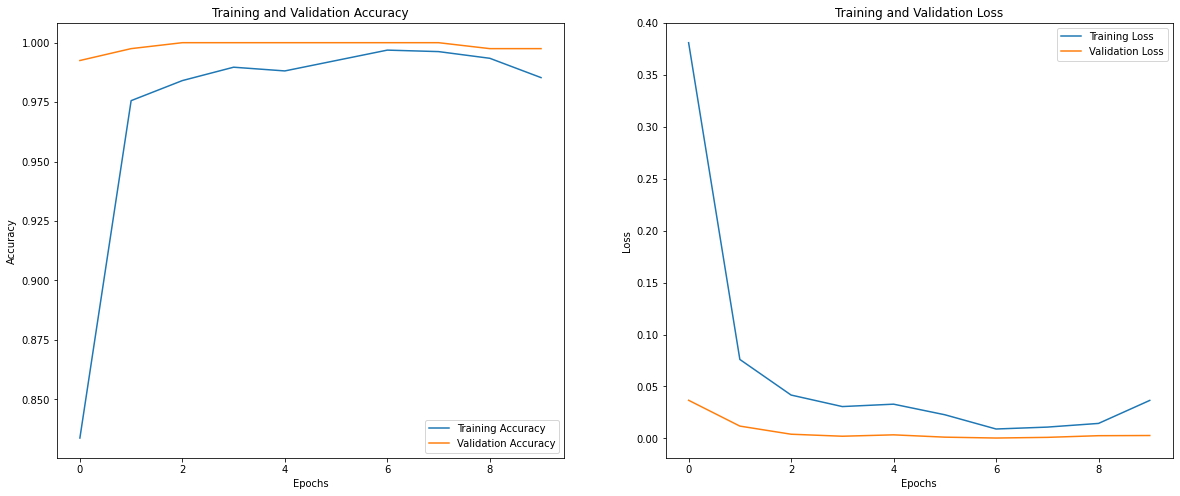

In [ ]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# x-axis
epochs_range = range(epochs)

# First figure: Model Accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Second figure: Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

## 09. Model Prediction

In [ ]:
class_names = np.array(['SANGYOON','UNIDENTIFIED'])

image_batch, label_batch = next(iter(test_data_gen))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED' 'UNIDENTIFIED' 'UNIDENTIFIED'
 'SANGYOON' 'UNIDENTIFIED' 'SANGYOON' 'SANGYOON' 'SANGYOON' 'SANGYOON'
 'UNIDENTIFIED' 'UNIDENTIFIED' 'SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED'
 'SANGYOON' 'SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED' 'SANGYOON'
 'UNIDENTIFIED' 'SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED' 'SANGYOON'
 'SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED' 'UNIDENTIFIED' 'UNIDENTIFIED'
 'UNIDENTIFIED' 'SANGYOON' 'SANGYOON' 'SANGYOON' 'UNIDENTIFIED'
 'UNIDENTIFIED' 'UNIDENTIFIED' 'SANGYOON' 'UNIDENTIFIED' 'SANGYOON'
 'UNIDENTIFIED' 'SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED' 'UNIDENTIFIED'
 'SANGYOON' 'SANGYOON' 'SANGYOON' 'SANGYOON' 'UNIDENTIFIED' 'SANGYOON'
 'UNIDENTIFIED' 'SANGYOON' 'UNIDENTIFIED' 'SANGYOON' 'SANGYOON'
 'UNIDENTIFIED' 'SANGYOON' 'SANGYOON' 'SANGYOON' 'SANGYOON' 'UNIDENTIFIED'
 'SANGYOON' 'UNIDENTIFIED' 'SANGYOON' 'UNIDENTIFIED' 'SANGYOON' 'SANGYOON'
 'SANGYOON' 'SANGYOON' 'UNIDENTIFIED' 'UNIDENTIFIED' 'UNIDENTIFIED'
 'UNIDENTIFIED' 'SANGYOO

In [ ]:
print("Labels:\n", label_batch.astype('int64'))
print("Predicted labels:\n", predicted_ids)

Labels:
 [0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1]
Predicted labels:
 [0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1]


Visualize the model prediction.

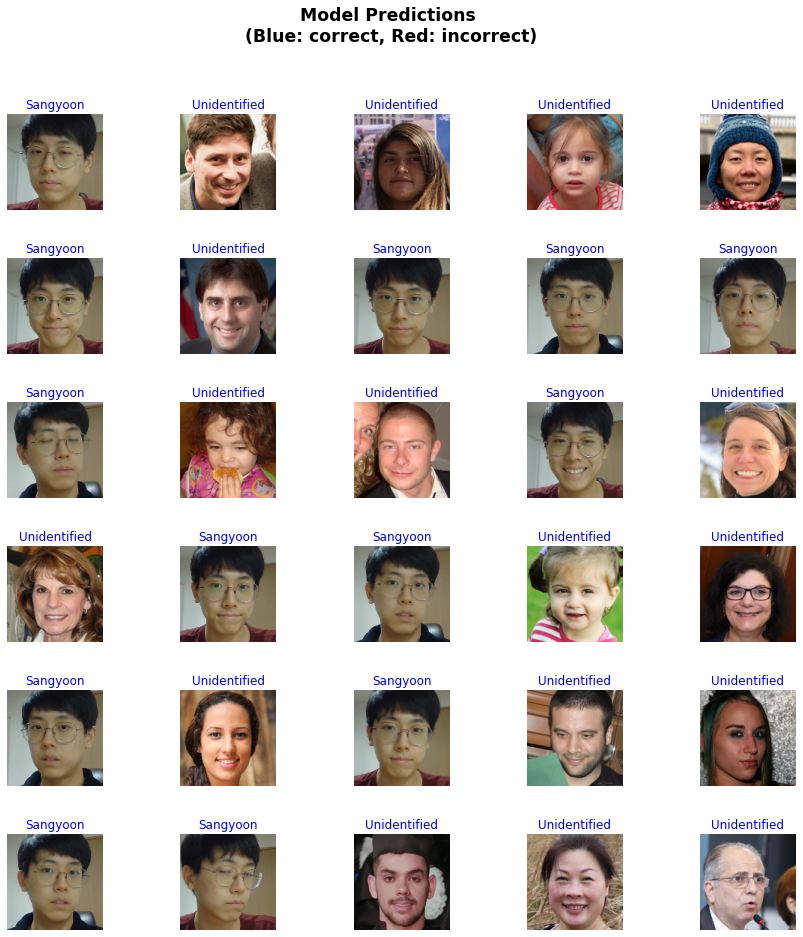

In [ ]:
plt.figure(figsize=(15,15))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(image_batch[n])

  if predicted_ids[n] == label_batch[n]:
    color = "blue" 
  else:
    color = "red"

  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions\n (Blue: correct, Red: incorrect)", 
                 fontsize='xx-large', fontweight='bold')

## 10. Export Model

Save the CNN model created above.

In [ ]:
filename = "face_recog_model"

export_path_sm = "./{}".format(filename)
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./face_recog_model


Convert the Keras to a frozen graph as a pb file.

In [ ]:
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))

full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

In [ ]:
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/content/",
                  name="frozen_graph.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 
x
sequential/conv2d/Conv2D/ReadVariableOp/resource
sequential/conv2d/Conv2D/ReadVariableOp
sequential/conv2d/Conv2D
sequential/conv2d/BiasAdd/ReadVariableOp/resource
sequential/conv2d/BiasAdd/ReadVariableOp
sequential/conv2d/BiasAdd
sequential/conv2d/Relu
sequential/max_pooling2d/MaxPool
sequential/conv2d_1/Conv2D/ReadVariableOp/resource
sequential/conv2d_1/Conv2D/ReadVariableOp
sequential/conv2d_1/Conv2D
sequential/conv2d_1/BiasAdd/ReadVariableOp/resource
sequential/conv2d_1/BiasAdd/ReadVariableOp
sequential/conv2d_1/BiasAdd
sequential/conv2d_1/Relu
sequential/max_pooling2d_1/MaxPool
sequential/conv2d_2/Conv2D/ReadVariableOp/resource
sequential/conv2d_2/Conv2D/ReadVariableOp
sequential/conv2d_2/Conv2D
sequential/conv2d_2/BiasAdd/ReadVariableOp/resource
sequential/conv2d_2/BiasAdd/ReadVariableOp
sequential/conv2d_2/BiasAdd
sequential/conv2d_2/Relu
sequential/max_pooling2d_2/MaxPool
sequential/flatten/Const
sequent

'/content/frozen_graph.pb'